In [127]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pyvinecopulib as pv

def expand(a_vec):
    if len(a_vec.shape) == 2:
        return a_vec
    else:
        return a_vec[:, None]

def get(U, i):
    assert i >= 1
    assert len(U.shape) == 2
    assert i <= U.shape[1]
    return expand(U[:,int(i-1)])

In [128]:
n = 1000

In [129]:
structure = pv.CVineStructure.simulate(d=4)

d = structure.dim
pair_copulas = []
for i in range(d-1):
    tmp = []
    pair_copulas.append(tmp)
    for j in range(d-i-1):
        tmp.append(pv.Bicop(family=pv.BicopFamily.gaussian, parameters=[[0.2+np.random.uniform()/100]]))

cop = pv.Vinecop(structure, pair_copulas)

In [130]:
U = cop.simulate(n=n)

In [131]:
# empty V matrix
V = []
for i in range(d):
    tmp = []
    V.append(tmp)
    for j in range(d):
        tmp.append(np.nan)

for j in range(d):
    V[0][j] = get(U, cop.matrix[j, d-j-1])
    print(f'V({0},{j}) - {cop.matrix[j, d-j-1]}')
    for i in range(1, j+1):
        t = i-1
        e = d-1-j
        bicop = cop.get_pair_copula(t,e)
        V[i][j] = expand(bicop.hfunc2(np.hstack([V[i-1][j], V[i-1][i-1]])))
        print(f'V({i},{j}) = [({i-1},{j}), ({i-1},{i-1})] - {cop.matrix[d-1-e, e]},{cop.matrix[t,e]}')

V(0,0) - 4
V(0,1) - 2
V(1,1) = [(0,1), (0,0)] - 2,4
V(0,2) - 3
V(1,2) = [(0,2), (0,0)] - 3,4
V(2,2) = [(1,2), (1,1)] - 3,2
V(0,3) - 1
V(1,3) = [(0,3), (0,0)] - 1,4
V(2,3) = [(1,3), (1,1)] - 1,2
V(3,3) = [(2,3), (2,2)] - 1,3


In [134]:
sample = np.zeros(shape=(n,1))
for i in range(100):
    w = expand(np.random.uniform(size=n))
    inv1 = expand(cop.get_pair_copula(2,0).hinv1(np.hstack([w, V[2][2]])))
    inv2 = expand(cop.get_pair_copula(1,0).hinv1(np.hstack([inv1, V[1][1]])))
    u_imp = expand(cop.get_pair_copula(0,0).hinv1(np.hstack([inv2, V[0][0]])))

    sample += u_imp

1 0.24290938930784084 True
2 0.39540587622639867 False
3 0.3090207465112025 False
4 0.977841279597364 False


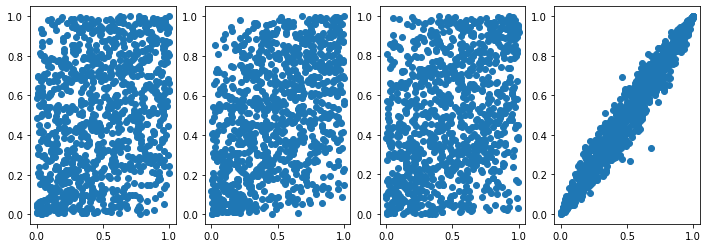

In [135]:
fig, axes = plt.subplots(1,d,figsize=(12,4))
for i in range(1,d+1):
    print(i, np.corrcoef(np.ravel(sample/100), np.ravel(get(U,i)))[0][1], i == cop.matrix[d-1,0])
    axes[i-1].scatter(sample/100, get(U, i))